<a href="https://colab.research.google.com/github/pazamelin/clinguistics_labs/blob/main/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text generation with deep learning

In [ ]:
import sys
import os
import os.path
import random
import collections
import shutil
import time
import glob
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets



%matplotlib inline


from bokeh.io import show,output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, BasicTicker, PrintfTickFormatter,ColorBar
from bokeh.models import FuncTickFormatter
from bokeh.plotting import figure

output_notebook()

**Задача**

   Обучить character recurrent neural network (char RNN) на датасете статей arxiv, а также на своих данных и исследовать её свойства.

Определим структуру сети, в качестве основного блока используем **GRU**

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, batch_first=True):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)
    
    def save_model(model, filename='rnn.ckpt'):
        checkpoint = {'input_size': model.input_size,
                      'hidden_size': model.hidden_size,
                      'output_size': model.output_size,
                      'n_layers': model.n_layers,
                      'state_dict': model.state_dict()}
        with open(filename, 'wb') as f:
            torch.save(checkpoint, f)

    def load_model(filename):

        with open(filename, 'rb') as f:
            checkpoint = torch.load(f)

        model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], n_layers=checkpoint['n_layers'])
        model.load_state_dict(checkpoint['state_dict'])

        return model

# Пример реализации класса для получения данных из датасета

In [ ]:
class TextDataset(Dataset):
    def __init__(self, text, chunk_len=10):
        self.chunks_number = int(len(text) / chunk_len)
        print(f'chunks: {self.chunks_number}')
        self.chunk_len = chunk_len
        self.text = text
        self.all_symbols = list({x for x in self.text})
    
    def __len__(self):
        return self.chunks_number
    
    def _get_tensor(self, text):
        return torch.LongTensor(list(map(self.all_symbols.index, text))).cuda()
    
    def _decode_vector(self, text):
        text = text.view(-1).cpu().detach().numpy()
        if text.shape[0] == 1:
            text = list(text)
        print(f'x - {text[0]}')
        return ''.join([self.all_symbols[x] for x in text])
    
    def _get_random_slice(self):
        start_index = random.randint(0, len(self.text) - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
        return self.text[start_index:end_index]
    
    def __getitem__(self, idx):
        chunk = self._get_random_slice()
        return self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:])

# Здесь должен быть код для считывания данных и создания даталоадера

In [ ]:
# download the file from google-drive
!pip install --quiet gdown
!gdown --id 1ZzxFJBdyz56b1AKVRFWxw9y9UPkeC1AS
!ls -l

# import as a pandas DataFrame
dataset_raw = pd.read_csv('arxiv.csv')
dataset_raw.drop(['time', 'favorites', 'rts', 'authors', 'category', 'published', 'tweeted'], axis=1, inplace=True)
dataset_raw

Downloading...
From: https://drive.google.com/uc?id=1ZzxFJBdyz56b1AKVRFWxw9y9UPkeC1AS
To: /content/arxiv.csv
100% 34.3M/34.3M [00:00<00:00, 119MB/s]
total 33484
-rw-r--r-- 1 root root 34280741 Mar 14 20:02 arxiv.csv
drwxr-xr-x 1 root root     4096 Mar  9 14:48 sample_data


,link,summary,title
0,arxiv.org/abs/1611.10003,In summary of the research findings presented ...,Vocabulary and the Brain: Evidence from Neuroi...
1,arxiv.org/abs/1611.10007,"In this paper, structural controllability of a...",Structural Controllability of Multi-Agent Netw...
2,arxiv.org/abs/1611.10010,We present a Deep Cuboid Detector which takes ...,Deep Cuboid Detection: Beyond 2D Bounding Boxes
3,arxiv.org/abs/1611.10012,"In this paper, we study the trade-off between ...",Speed/accuracy trade-offs for modern convoluti...
4,arxiv.org/abs/1611.10014,"In this paper, we propose a characterization o...",Characterization and Efficient Exhaustive Sear...
...,...,...,...
27183,arxiv.org/abs/1710.04176,Being motivated by the multilayer RECOS (REcti...,On Data-Driven Saak Transform
27184,arxiv.org/abs/1710.04177,"Understanding tie strength in social networks,...",The Social Bow Tie
27185,arxiv.org/abs/1710.04196,"We present pyroomacoustics, a software package...",Pyroomacoustics: A Python package for audio ro...
27186,arxiv.org/abs/1710.04200,Joint image filters leverage the guidance imag...,Joint Image Filtering with Deep Convolutional ...


In [ ]:
summaries_list = dataset_raw['summary'].tolist()
summaries_text = ' '.join(summaries_list) 
summaries_text = summaries_text[:5000]
summaries_text = summaries_text.split()
print(summaries_text)

# Parameters
params = {
    # 'batch_size': 0,
    # 'shuffle': True,
    # 'num_workers': 1
}

torch.multiprocessing.set_start_method("spawn", force=True)

# Generators
arxiv_dataset = TextDataset(text=summaries_text, chunk_len=100)
arxiv_generator = torch.utils.data.DataLoader(arxiv_dataset, **params)

['In', 'summary', 'of', 'the', 'research', 'findings', 'presented', 'in', 'this', 'paper,', 'various', 'brain', 'regions', 'are', 'correlated', 'with', 'vocabulary', 'and', 'vocabulary', 'acquisition.', 'Semantic', 'associations', 'for', 'vocabulary', 'seem', 'to', 'be', 'located', 'near', 'brain', 'areas', 'that', 'vary', 'according', 'to', 'the', 'type', 'of', 'vocabulary,', 'e.g.', 'ventral', 'temporal', 'regions', 'important', 'for', 'words', 'for', 'things', 'that', 'can', 'be', 'seen.', 'Semantic', 'processing', 'is', 'believed', 'to', 'be', 'strongly', 'associated', 'with', 'the', 'ANG.', 'Phonological', 'ability', 'has', 'been', 'closely', 'related', 'to', 'the', 'anterior', 'surfaces', 'of', 'the', 'SMG.', 'Pathways', 'through', 'the', 'posterior', 'SMG', 'are', 'thought', 'to', 'link', 'the', 'anterior', 'SMG', 'and', 'the', 'ANG.', 'In', 'vocabulary', 'tasks,', 'mediotemporal', 'structures', 'may', 'be', 'related', 'to', 'long-term', 'memory', 'processing,', 'with', 'left', 

Смотрим, сколько уникальных символов есть в датасете - это и будет размер выходного вектора у нейронной сети

In [ ]:
unique_symbols = len(arxiv_dataset.all_symbols)
n_layers = 2
hidden_size = 100

In [ ]:
unique_symbols

400

In [ ]:
net = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)

In [ ]:
device = torch.device("cuda")

In [ ]:
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Здесь нужно реализовать функцию для генерации текста с помощью сети

In [ ]:
def generate(net, device, dataset, prime_str='In', predict_len=10, temperature=0.8):
    #Code to generate string based on input sequence (prime_str)
    hidden = net.init_hidden().cuda()

    for p in range(predict_len):        
        prime_input = dataset._get_tensor(prime_str.split())
        inp = prime_input[-1:] #last word as input
        output, hidden = net(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted word to string and use as next input
        predicted_word = dataset.all_symbols[top_i.item()]
        prime_str += ' ' + predicted_word

    return prime_str


generate(net, device, arxiv_dataset)   

'In effectively near multi-agent takes system, convolutional previously quantitative art resolution,'

# Здесь должен быть цикл тренировки

In [ ]:
epochs = 10000

In [ ]:
start = time.time()
all_losses = []
temperature = 0.8

for epoch in range(1, epochs+1):
  # #Your code for training here
  for local_batch, local_labels in arxiv_generator:
    for input, label in zip(local_batch, local_labels):
      hidden = net.init_hidden().cuda()
      net.zero_grad()
      loss = 0

      # get output
      output, hidden = net(input[-1:].cuda(), hidden)
      output_dist = output.data.view(-1).div(temperature).exp()
      word_index = torch.multinomial(output_dist, 1)
      predicted_word = arxiv_dataset.all_symbols[word_index.item()]
      
      # compute loss
      loss = criterion(output, label[-1:].view(-1).long())

      loss.backward()
      optimizer.step()
      all_losses.append(loss.data.item())

print("Saving...")
RNN.save_model(net, "TrainedModel.ckpt")

Saving...


In [ ]:
net(input[-1:], hidden)[0].shape

torch.Size([1, 400])

In [ ]:
label[-1:]

tensor([230], device='cuda:0')

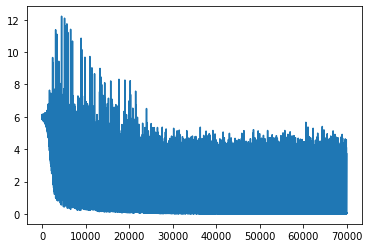

In [ ]:
plt.figure()
plt.plot(all_losses)

## Результаты тренировки

In [ ]:
generated_text = generate(net, device, arxiv_dataset, 'In this research', 200 )
print(generated_text)

In this research proposals. We present a consumer-quality RGB failures in such as the failure of the failure of feature extractors, such codes. These sets are of box-like objects. We consider three main culprits in the speed-accuracy tradeoff curve, ranging from low-level cues like corners, edges, and agents is introduced and their important properties are exploited to classical approaches which fit a approaches art on convolutional neural networks. We localize of the error state of the large variety of many different points on convolutional neural networks. We develop a leader-follower multi-agent system, and agents is suitable for remaining controllable following the communication links and auditory joint t-controllability are introduced and their important properties are associated with some useful indices and sufficient condition for irregular low-density parity-check (LDPC) codes. participate in the trade-off between accuracy and working memory, respectively. Precentral structures

# Здесь должны быть эксперименты с архитектурой и параметрами сети

In [ ]:
!pip install alive_progress
import alive_progress

def get_losses(num_layers=1, lr=1e-4, temperature=0.8, epochs=3000):
  net = RNN(unique_symbols, hidden_size, unique_symbols, num_layers)
  device = torch.device("cuda")
  net = net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  # 
  all_losses = []
  with alive_progress.alive_bar(epochs) as bar:
    for epoch in range(1, epochs+1):
      # #Your code for training here
      for local_batch, local_labels in arxiv_generator:
        for input, label in zip(local_batch, local_labels):
          hidden = net.init_hidden().cuda()
          net.zero_grad()
          loss = 0

          # get output
          output, hidden = net(input[-1:].cuda(), hidden)
          output_dist = output.data.view(-1).div(temperature).exp()
          word_index = torch.multinomial(output_dist, 1)
          predicted_word = arxiv_dataset.all_symbols[word_index.item()]
      
          # compute loss
          loss = criterion(output, label[-1:].view(-1).long())

          loss.backward()
          optimizer.step()
          all_losses.append(loss.data.item())
      bar()
  return all_losses

     |████████████████████████████████| 79 kB 2.1 MB/s 
     |████████████████████████████████| 207 kB 34.0 MB/s 
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210096 sha256=8f5e7bc8e36dc9565d9fb65e2a93b374f1b4377ebba20c613c2f95af899b3880
  Stored in directory: /root/.cache/pip/wheels/71/fc/c8/142ef03b79c02b618fe80b9f2d01c25bd55f60b0c58eab3f0e
Successfully built grapheme


In [ ]:
n_layers = [1, 2, 3]
total_losses = []

for n in n_layers:
  total_losses.append(get_losses(num_layers=n))

|████████████████████████████████████████| 3000/3000 [100%] in 1:30.0 (33.33/s)
|████████████████████████████████████████| 3000/3000 [100%] in 1:31.1 (32.93/s)
|████████████████████████████████████████| 3000/3000 [100%] in 1:43.4 (29.01/s)


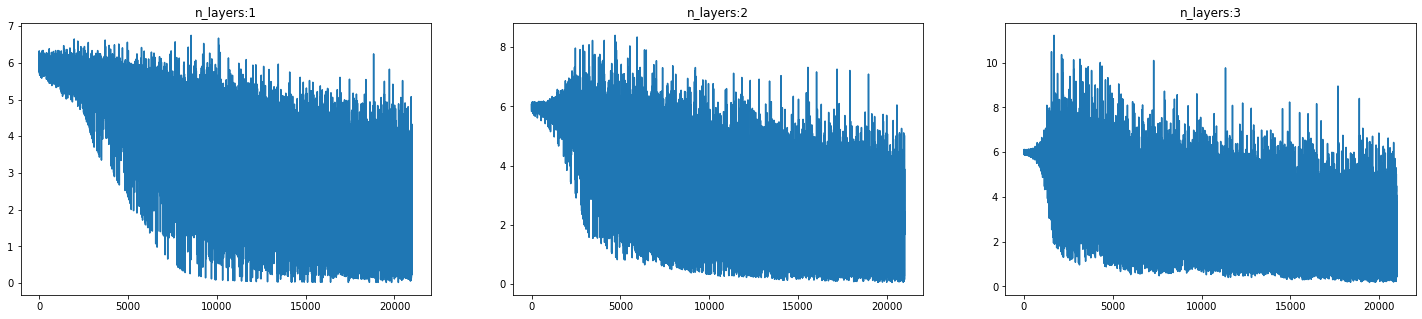

In [ ]:
fig, axs = plt.subplots(1, len(n_layers), figsize=(25,5))

for ax, n, al in zip(axs.flat, n_layers, total_losses):
    ax.set_title(f'n_layers:{n}')
    ax.plot(al)

из-за большого разброса при подсчете loss трудно выявить наличие или отсутствие какого-то влияния от количества слоев(

# Здесь будет работа с вашими датасетами (которые вы захотите использовать)

In [ ]:
from os import listdir
from os.path import isfile, join
import json
import pathlib

BASE_PATH = 'clinguistics_labs'

if not os.path.exists(BASE_PATH):
  ! git clone https://github.com/aailyinh/clinguistics_labs.git

DATASET_PATH = f'{BASE_PATH}/Arzamas/texts'

texts = []

files = [f for f in listdir(DATASET_PATH) if isfile(join(DATASET_PATH, f))]
files = sorted(files)

Cloning into 'clinguistics_labs'...
remote: Enumerating objects: 687, done.
remote: Counting objects: 100% (687/687), done.
remote: Compressing objects: 100% (667/667), done.
remote: Total 687 (delta 30), reused 661 (delta 11), pack-reused 0
Receiving objects: 100% (687/687), 68.71 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Checking out files: 100% (651/651), done.


In [ ]:
for fn in files:
		full_fn = f'{DATASET_PATH}/{fn}'
		#print(full_fn)
		with open(full_fn) as txt_file:
			data = txt_file.read()
			texts.append(data)

In [ ]:
summaries_text = ' '.join(texts) 
summaries_text = summaries_text[:5000]
summaries_text = summaries_text.split()
print(summaries_text)

# Parameters
params = {
    # 'batch_size': 0,
    # 'shuffle': True,
    # 'num_workers': 1
}

torch.multiprocessing.set_start_method("spawn", force=True)

# Generators
russian_dataset = TextDataset(text=summaries_text, chunk_len=100)
russian_generator = torch.utils.data.DataLoader(russian_dataset, **params)

['Работа', 'под', 'названием', '"Захоронение', 'Нефертити?"', 'опубликована', 'на', 'научном', 'сайте', 'academia.edu.', 'Николас', 'Ривз,', 'египтолог', 'Института', 'Аризоны,', 'изучил', 'фотографии', 'и', '3D-сканы', 'гробницы,', 'сделанные', 'в', 'начале', 'года', 'компанией', 'Factum', 'Ave,', 'и,', 'как', 'он', 'считает,', 'увидел', 'следы', 'двух', 'дверей,', 'ведущих', 'в', 'скрытые', 'помещения,', 'одно', 'из', 'которых,', 'возможно,', 'является', 'сокровищницей,', 'а', 'другое', '--', 'местом', 'захоронения', 'царицы', '(на', 'что', 'якобы', 'указывают', 'и', 'фрески', 'на', 'стене).', 'Нефертити,', 'как', 'многие', 'полагают,', 'была', 'матерью', 'Тутанхамона,', 'но', 'как', 'получилось,', 'что', 'мать', 'тайно', 'похоронили', 'в', 'гробнице', 'сына?', 'Или,', 'точнее', '(как', 'формулирует', 'Ривз),', 'сына', '--', 'в', 'гробнице', 'матери?', 'Это', 'редкий', 'пример', 'научной', 'работы,', 'которая', 'читается', 'как', 'детектив.', 'Те,', 'кому', 'лень', 'изучать', 'ее', '

In [ ]:
unique_symbols = len(russian_dataset.all_symbols)
n_layers = 2
hidden_size = 100

net_2 = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)
device = torch.device("cuda")
net_2 = net_2.to(device)
optimizer = torch.optim.Adam(net_2.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 10000

start = time.time()
all_losses_2 = []
temperature = 0.8

for epoch in range(1, epochs+1):
  # #Your code for training here
  for local_batch, local_labels in russian_generator:
    for input, label in zip(local_batch, local_labels):
      hidden = net_2.init_hidden().cuda()
      net_2.zero_grad()
      loss = 0

      # get output
      output, hidden = net_2(input[-1:].cuda(), hidden)
      output_dist = output.data.view(-1).div(temperature).exp()
      word_index = torch.multinomial(output_dist, 1)
      predicted_word = russian_dataset.all_symbols[word_index.item()]
      
      # compute loss
      loss = criterion(output, label[-1:].view(-1).long())

      loss.backward()
      optimizer.step()
      all_losses_2.append(loss.data.item())

print("Saving...")
RNN.save_model(net_2, "TrainedModel.ckpt")

Saving...


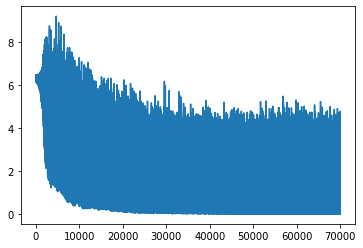

In [ ]:
plt.figure()
plt.plot(all_losses_2)

In [ ]:
!pip install alive_progress
import alive_progress


def get_losses(num_layers=1, lr=1e-4, temperature=0.8, epochs=3000):
  net = RNN(unique_symbols, hidden_size, unique_symbols, num_layers)
  device = torch.device("cuda")
  net = net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  # 
  all_losses = []
  with alive_progress.alive_bar(epochs) as bar:
    for epoch in range(1, epochs+1):
      # #Your code for training here
      for local_batch, local_labels in russian_generator:
        for input, label in zip(local_batch, local_labels):
          hidden = net.init_hidden().cuda()
          net.zero_grad()
          loss = 0

          # get output
          output, hidden = net(input[-1:].cuda(), hidden)
          output_dist = output.data.view(-1).div(temperature).exp()
          word_index = torch.multinomial(output_dist, 1)
          predicted_word = russian_dataset.all_symbols[word_index.item()]
      
          # compute loss
          loss = criterion(output, label[-1:].view(-1).long())

          loss.backward()
          optimizer.step()
          all_losses.append(loss.data.item())
      bar()
  return all_losses

In [ ]:
n_layers = [1, 2, 3]
total_losses = []

for n in n_layers:
  total_losses.append(get_losses(num_layers=n))

|████████████████████████████████████████| 3000/3000 [100%] in 1:33.7 (32.03/s)
|████████████████████████████████████████| 3000/3000 [100%] in 1:37.8 (30.66/s)
|████████████████████████████████████████| 3000/3000 [100%] in 1:48.6 (27.62/s)


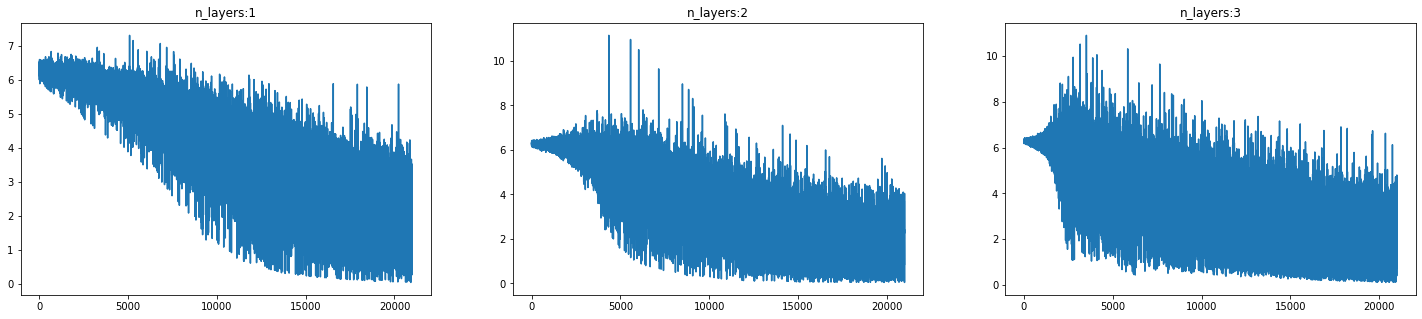

In [ ]:
fig, axs = plt.subplots(1, len(n_layers), figsize=(25,5))

for ax, n, al in zip(axs.flat, n_layers, total_losses):
    ax.set_title(f'n_layers:{n}')
    ax.plot(al)